El servicio de venta de autos usados Rusty Bargain está desarrollando una aplicación para atraer nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial: especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.
A Rusty Bargain le interesa:
- la calidad de la predicción;
- la velocidad de la predicción;
- el tiempo requerido para el entrenamiento

## 1. Preparación de datos

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model
import time
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from lightgbm import LGBMRegressor

### 1.1 Cargar y explorar los datos. 

In [ ]:
# Importando dataset
url = 'https://github.com/Ramon-Bravo/datasets_publicos/raw/refs/heads/main/car_data.csv.gz'
df = pd.read_csv(url, compression= 'gzip')

# Muestra de datos

df.sample(5)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
25861,15/03/2016 23:47,1500,wagon,1999,auto,150,a4,150000,7,gasoline,audi,no,15/03/2016 00:00,0,48308,05/04/2016 12:47
168173,30/03/2016 23:47,1500,wagon,2002,manual,150,laguna,150000,12,gasoline,renault,NaN,30/03/2016 00:00,0,66117,05/04/2016 17:45
188004,16/03/2016 14:37,7999,convertible,2000,manual,179,tt,125000,4,petrol,audi,no,03/02/2016 00:00,0,39126,07/04/2016 13:17
283058,15/03/2016 11:47,2200,wagon,2003,manual,101,fabia,150000,3,gasoline,skoda,no,15/03/2016 00:00,0,93055,28/03/2016 00:15
244208,02/04/2016 17:57,600,small,1996,manual,58,twingo,150000,10,petrol,renault,NaN,02/04/2016 00:00,0,33729,02/04/2016 17:57


In [3]:
# Comprobacion de tipos de datos. 

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### 1.2 Limpieza de datos.

In [5]:
# Copia del dataset original. 

df_limpio = df.copy()

# Eliminando columnas que no ayudan al modelo. 

cols_eliminar = ['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures', 'PostalCode', 'RegistrationMonth']

df_limpio.drop(columns=cols_eliminar, inplace=True)

In [6]:
df_limpio.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,gasoline,skoda,no


In [7]:
# Valores nulos por columna

vals_nulos = df_limpio.isnull().sum().sort_values(ascending=False)

vals_nulos

NotRepaired         71154
VehicleType         37490
FuelType            32895
Gearbox             19833
Model               19705
Price                   0
Power                   0
RegistrationYear        0
Mileage                 0
Brand                   0
dtype: int64

#### 1.2.1 VALORES ATÍPICOS

In [8]:
# Valores atípicos cuantitativos

vals_atipicos = df_limpio[['Price', 'Power', 'RegistrationYear', 'Mileage']].describe()

vals_atipicos


,Price,Power,RegistrationYear,Mileage
count,354369.000000,354369.000000,354369.000000,354369.000000
mean,4416.656776,110.094337,2004.234448,128211.172535
std,4514.158514,189.850405,90.227958,37905.341530
min,0.000000,0.000000,1000.000000,5000.000000
25%,1050.000000,69.000000,1999.000000,125000.000000
50%,2700.000000,105.000000,2003.000000,150000.000000
75%,6400.000000,143.000000,2008.000000,150000.000000
max,20000.000000,20000.000000,9999.000000,150000.000000


**- Se nota que en la columna 'Price' hay observaciones que cuentan con valor 0, lo que no tiene sentido. De iual forma para la columna 'Power' con valores mínimos de 0 y máximos de 20,000 caballos de vapor, y para la columna 'RegistrationYear' con años desde 1000 a 9999. En el paso siguiente realizaré un filtrado de datos para no tomar en cuenta los valores atípicos que afecten las predicciones del modelo.**

In [9]:
# filtrado de datos. 

df_limpio = df_limpio[(df_limpio['Power'] >= 30) & (df_limpio['Power'] <= 500)]
df_limpio = df_limpio[(df_limpio['Price'] >= 500) & (df_limpio['Power'] <= 50000)]
df_limpio = df_limpio[(df_limpio['RegistrationYear'] >= 1950) & (df_limpio['RegistrationYear'] <= 2022)]

df_limpio.shape

(288447, 10)

**Considero que los valores que filtré en la celda anterior son los datos que ayudarán al modelo a realizar mejores predicciones.**

#### 1.2.2 VALORES NULOS

In [10]:
# Valores nulos después del filtrado de datos. 

vals_nulos_i = df_limpio.isnull().sum().sort_values(ascending=False)
vals_nulos_i = vals_nulos_i[vals_nulos_i > 0]

vals_nulos_i

NotRepaired    40511
VehicleType    18215
FuelType       16591
Model          10715
Gearbox         5076
dtype: int64

`NotRepaired`

In [11]:
# Rellenando columna NotRepaired con categoría nueva "unknown_repair", no se eliminan porque perderíamos 40 mil datos, y sería incorrceto sustituir con la moda porque se podrían omitir 
# vehículos con daños, y considero que esta característica tiene mucho impacto en el precio. 

df_limpio.fillna({'NotRepaired': 'unknown_repair'}, inplace=True)

df_limpio['NotRepaired'].isnull().sum()


np.int64(0)

`VehicleType`

In [12]:
# Reemplazando valores nulos en la columna VehicleType con categoría "unknown_type", la razón por la que no se eliminan se debe a que perderíamos mas de 18 mil observaciones
# tampoco sería conveniente para el modelo reemplazarlos con el valor con mayor frecuencia porque introduciría sesgo. 

df_limpio.fillna({'VehicleType': 'unknown_type'}, inplace=True)

df_limpio['VehicleType'].isnull().sum()

np.int64(0)

`FuelType`

In [13]:
df_limpio['FuelType'].value_counts()

FuelType
petrol      177773
gasoline     88612
lpg           4696
cng            482
hybrid         203
other           54
electric        36
Name: count, dtype: int64

In [14]:
# Reemplazando valores nulos en la columna FuelType con el valor mas frecuente 'petrol', aunque podría ser que esté duplicado con "gasoline" (revisión posteriormente), 
# la razón por la que no se eliminan se debe a que perderíamos mas de 16 mil observaciones

df_limpio.fillna({'FuelType': 'petrol'}, inplace=True)

df_limpio['FuelType'].isnull().sum()

np.int64(0)

In [15]:
# homologando columna FuelType "Petrol" y "gasoline"

df_limpio['FuelType'] = df_limpio['FuelType'].replace('gasoline', 'petrol')

tipo_combustible = df_limpio['FuelType'].value_counts()

tipo_combustible

FuelType
petrol      282976
lpg           4696
cng            482
hybrid         203
other           54
electric        36
Name: count, dtype: int64

`Model`

In [16]:
#Rellenando columna Model con categoría nueva "unknown_model", no se eliminan porque perderíamos 10 mil datos, y sería incorrceto sustituir con la moda porque no coincidiría con la marca. 

df_limpio.fillna({'Model': 'unknown_model'}, inplace=True)

df_limpio['Model'].isnull().sum()

np.int64(0)

`Gearbox`

In [17]:
#Rellenando columna `Gearbox` con valor con mayor frecuencia, no se eliminan porque perderíamos 5 mil datos 

df_limpio.fillna({'Gearbox': 'manual'}, inplace=True)

df_limpio['Gearbox'].isnull().sum()

np.int64(0)

### 1.3 Análisis exploratorio. 

- Decidí agregar esta parte al proyecto, debido a que es un paso importante para el cómo y el por qué el/los modelos podrían entregar predicciones correctas. Además de que me ayuda a refrescar y practicar el tema. 

#### 1.3.1 Matriz de Correlación. 

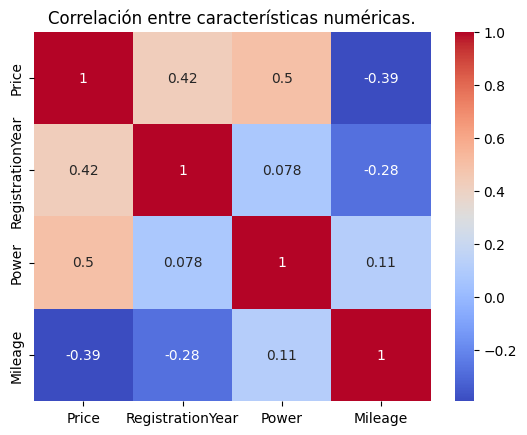

In [18]:
# Matriz de correlación entre características numéricas y el precio

caracteristicas_num = ['Price', 'RegistrationYear', 'Power', 'Mileage']
matriz_correlacion = df_limpio[caracteristicas_num].corr()

sns.heatmap(matriz_correlacion, annot=True, cmap='coolwarm')
plt.title('Correlación entre características numéricas.')
plt.show()


#### 1.3.2 Diagráma de caja. 

**- Como se puede observar en el gráfico anterior, existe una gran conexión ebtre las variables numéricas, y a su vez, estas influyen en el precio, es decir, entre menor sea el año de registro mayor será el precio del vehículo. Lo mismo pasa con la columna Power, ya que a mayor capacidad del motor el precio del coche aumenta.**

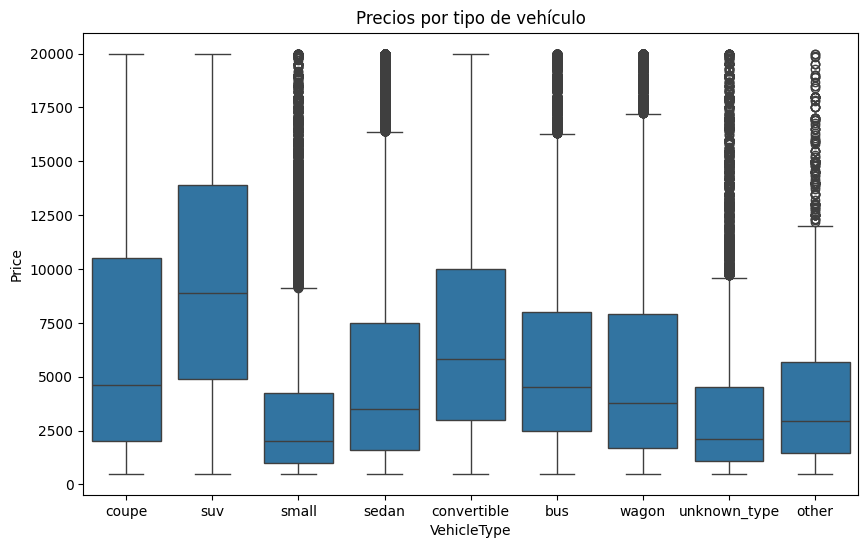

In [19]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df_limpio, x='VehicleType', y='Price')
plt.title('Precios por tipo de vehículo')
plt.show()

**- En la figura anterior se observa una comparacion de los precios por cada tipo de vehpiculo, y haciendo un ejercicio mental rápído, la visualizacion tiene lógica, ya que los coches descapotables y las SUV tienen precios mas altos en el mercado.**

In [20]:
df_limpio.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,FuelType,Brand,NotRepaired
1,18300,coupe,2011,manual,190,unknown_model,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown_repair
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


## 2. Entrenamiento del modelo. 

### 2.1 Preprocesamiento de los datos. 

In [21]:
# Copia del dataframe limpio. 

df_limpio_i = df_limpio.copy()

# Definiendo características y objetivo

X = df_limpio_i.drop(columns='Price')
y = df_limpio_i['Price']

# Definiendo columnas categóricas

cols_categoricas = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']
cols_numericas = ['RegistrationYear', 'Power', 'Mileage']

# Preprocesando columnas categóricas con OneHotEncoder y escalando columnas numpericas con StandardScaler

proprocesador = ColumnTransformer(transformers=[
    ('num', StandardScaler(), cols_numericas), 
    ('cat', OneHotEncoder(handle_unknown='ignore'), cols_categoricas)
])

# Definiendo conjunto de prueba y entrenamiento

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)

# Regresion lineal

pipeline_rl= Pipeline(steps=[('proprocesador', proprocesador), ('model', LinearRegression())])

pipeline_rl.fit(X_train, y_train)

Pipeline(steps=[('proprocesador',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['RegistrationYear', 'Power',
                                                   'Mileage']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['VehicleType', 'Gearbox',
                                                   'Model', 'FuelType', 'Brand',
                                                   'NotRepaired'])])),
                ('model', LinearRegression())])

In [ ]:
# Bosque aleatorio

pipeline_ba= Pipeline(steps=[('proprocesador', proprocesador), ('model', RandomForestRegressor(random_state=12345, n_estimators=50))])
pipeline_ba.fit(X_train, y_train)

### 2.2 Librería LightGBM

In [23]:
# Implementación de librería LightGMB 

pipeline_gbm = Pipeline(steps=[
    ('proprocesador', proprocesador),
    ('modelo', LGBMRegressor(n_estimators=300, learning_rate=0.1, random_state=12345, max_depth=10, min_child_samples=10, num_leaves=63))
])

pipeline_gbm.fit(X_train, y_train)
y_pred_lbm = pipeline_gbm.predict(X_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 920
[LightGBM] [Info] Number of data points in the train set: 230757, number of used features: 303
[LightGBM] [Info] Start training from score 5088.103585


## 3. Análisis de los modelos.

### 3.1 Calidad del modelo

In [24]:
# Calculo RMSE regresion lineal. 

y_pred_rl = pipeline_rl.predict(X_test)
rmse_rl = np.sqrt(mean_squared_error(y_test, y_pred_rl))

In [ ]:
# Calculo RMSE bosque aleatorio. 

y_pred_ba = pipeline_ba.predict(X_test)
rmse_ba = np.sqrt(mean_squared_error(y_test, y_pred_ba))

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Resultados EMSE regresion lineal // bosque aleatorio

resultados_rmse = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Bosque Aleatorio'], 
    'RMSE': [rmse_rl, rmse_ba]
})

resultados_rmse

,Modelo,RMSE
0,Regresión Lineal,2610.876919
1,Bosque Aleatorio,1577.821586


In [ ]:
# RMSE de resultados con librería LightGMB

rmse_lgbm = np.sqrt(mean_squared_error(y_test, y_pred_lbm))

print(f'RMSE LightGMB: {rmse_lgbm:.2f}')

RMSE LightGMB: 1579.13


In [ ]:
# Comparacion de RMSE de modelos

resultados_rmse_i = pd.DataFrame({
    'Modelo': ['Regresión Lineal', 'Bosque Aleatorio', 'LightGMB'], 
    'RMSE': [rmse_rl, rmse_ba, rmse_lgbm]
})
resultados_rmse_i


,Modelo,RMSE
0,Regresión Lineal,2610.876919
1,Bosque Aleatorio,1577.821586
2,LightGMB,1579.128038


In [ ]:
joblib.dump(pipeline_gbm, 'pipeline_lgbm_tuned.pkl')

['pipeline_lgbm_tuned.pkl']

### 3.2 Velocidad de los modelos.

%time // %timeit

In [ ]:
# %time pipeline_rl.fit(X_train, y_train)

%time pipeline_rl.predict(X_test)

In [30]:
# %time pipeline_ba.fit(X_train, y_train)

In [31]:
# %time pipeline_gbm.fit(X_train, y_train)

# Lista de control

Escribe 'x' para verificar. Luego presiona Shift+Enter

- [x]  Jupyter Notebook está abierto
- [ ]  El código no tiene errores- [ ]  Las celdas con el código han sido colocadas en orden de ejecución- [ ]  Los datos han sido descargados y preparados- [ ]  Los modelos han sido entrenados
- [ ]  Se realizó el análisis de velocidad y calidad de los modelos